In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
df = pd.read_csv('Concrete_Data.csv')
df.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


-- You can see here the various ingredients going into each variety of concrete. We'll see in a moment how adding some additional synthetic features derived from these can help a model to learn important relationships among them.


-- We'll first establish a baseline by training the model on the un-augmented dataset. This will help us determine whether our new features are actually useful.


-- Establishing baselines like this is good practice at the start of the feature engineering process. A baseline score can help you decide whether your new features are worth keeping, or whether you should discard them and possibly try something else.

In [ ]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Train and score baseline model
baseline = RandomForestRegressor(criterion='mae', random_state=0)

baseline_score = cross_val_score(baseline, X, y, cv=5, scoring='neg_mean_absolute_error')

baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\e

MAE Baseline Score: 8.232


If you ever cook at home, you might know that the *ratio* of ingredients in a recipe is usually a better predictor of how the recipe turns out than their absolute amounts. We might reason then that ratios of the features above would be a good predictor of **CompressiveStrength**.

In [ ]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Create Synthetic Features
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"]
X["AggCmRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"]
X["WtrCmtRatio"] = X["Water"]/X["Cement"]

# Train and score model on the dataset with additional ratio features
model = RandomForestRegressor(criterion='absolute_error', random_state=0)

score = cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error")
score = -1 * score.mean()

print(f"MAE Score with Ratio Features: {score:.4}")

MAE Score with Ratio Features: 7.948


And sure enough, performance improved! This is an evidence that these new ratio features exposed important information to the model that it wasn't detecting before.

### Mutual Information

First encountering a new dataset can sometimes feel overwhelming. You might be presented with hundreds or thousands of features without even a description to go by. Where do you even begin?

A great first step is to construct a ranking with a **feature utility metric**, a function measuring association between a feature and the target. Then you can choose a smaller subset of the most useful features to develop initially and have more confidence that your time will be well spent.

The metric we'll use is called "mutual information". Mutual Information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect *any* kind of relationship, while correlation only detects *linear* relatioships.

Mutual Information is a great general-purpose metric and especially useful at the start of feature development when you might not know what model you'd like to use yet. It is:

* easy to use and interpret,
* computationally efficient,
* theoretically well-founded,
* resistant to overfitting, and
* able to detect any kind of relationship

### Mutual Information and What it Measures

Mutual Information describes relationships in terms of *uncertainty.* The **mutual information** (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

(Technical note: What we're calling uncertainty is measured using a quantity from information theory known as "entropy". The entropy of a variable means roughly: "how many yes-or-no questions you would need to describe an occurance of that variable, on average." The more questions you have to ask, the more uncertain you must be about the variable. Mutual Information is how many questions you would expect the feature to answer about the target.)

Here are some things to remember when applying mutual information:

* MI can help you to understand the *relative potential* of a feature as a predictor of the target, considered by itself.

* It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI *can't detect interactions* between features. It is a **univariate** metric.

* The *actual* usefulness of a feature depends on the model you use it with. A feature is only useful to the extent that its relationship with the target is one your model can learn. Juse because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('seaborn-whitegrid')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cement               1030 non-null   float64
 1   BlastFurnaceSlag     1030 non-null   float64
 2   FlyAsh               1030 non-null   float64
 3   Water                1030 non-null   float64
 4   Superplasticizer     1030 non-null   float64
 5   CoarseAggregate      1030 non-null   float64
 6   FineAggregate        1030 non-null   float64
 7   Age                  1030 non-null   int64  
 8   CompressiveStrength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [ ]:
from sklearn.feature_selection import mutual_info_regression

In [ ]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [ ]:
mi_scores = make_mi_scores(X, y)
mi_scores[::3]

WtrCmtRatio         0.458194
Water               0.360355
CoarseAggregate     0.254071
BlastFurnaceSlag    0.181131
Name: MI Scores, dtype: float64

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

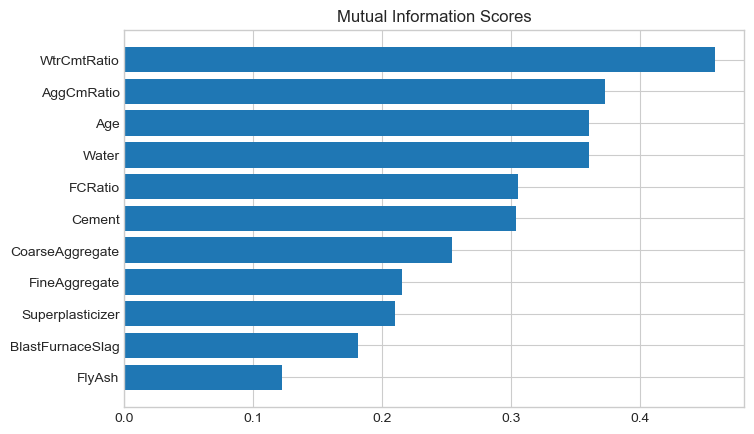

In [ ]:
plt.figure(dpi=100, figsize=(8,5))
plot_mi_scores(mi_scores)

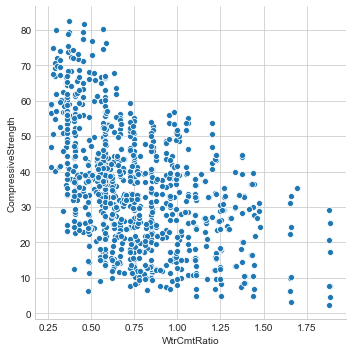

In [ ]:
sns.relplot(x='WtrCmtRatio', y='CompressiveStrength', data=df)

In [ ]:
df.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [ ]:
df['WtrCmtRatio'] = df['Water'] / df['Cement']

### Creating New Features

**Tips on Discovering New Features**

* Understand the features. Refer to your dataset's *data documentation*, if available.
* Research the problem domain to acquire **domain knowledge**. If your problem is predicting house prices, do some research on real-estate for instance. Wikipedia can be a good starting point, but books on https://scholar.google.com/ will often have the best information.
* Study previous work. Solution write-ups https://www.kaggle.com/code/sudalairajkumar/winning-solutions-of-kaggle-competitions/notebook from past Kaggle competitions are a great resource.
* Use data visualization. Visualization can reveal pathologies in the distribution of a feature or complicated relationships that could be simplified. Be sure to visualize your dataset as you work through the feature engineering process.

### Mathematical Transforms

Relationships among numerical fearures are often expressed through mathematical formulas, which you'll frequently come across as part of your domain research. In pandas, you can apply arithmetic operations to columns just as if they were ordinary numbers.

In [ ]:
# Ex: 

autos["stroke_ratio"] = autos.stroke / autos.bore

autos[["stroke", "bore", "stroke_ratio"]].head()

**Data visualization can suggest transformations, often a "reshaping" of a feature through powers or logarithms. The distribution of WindSpeed in US Accidents is highly skewed, for instance. In this case the logarithm is effective at normalizing it:**

In [ ]:
# If the feature has 0.0 values, use np.log1p (log(1+x)) instead of np.log
accidents["LogWindSpeed"] = accidents.WindSpeed.apply(np.log1p)

# Plot a comparison
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(accidents.WindSpeed, shade=True, ax=axs[0])
sns.kdeplot(accidents.LogWindSpeed, shade=True, ax=axs[1]);

![image.png](attachment:image.png)

### Counts

Features describing the presence or absence of something often come in sets, the set of risk factors for a disease, say. You can aggregate such features by creating a **count**.

These features will be binary (1 for Present, 0 for Absent) or *boolean* (True or False). In python, booleans can be added up just as if they were integers.

In *Traffic Accidents* are several features indicating whether some roadway object was near the accident. This will create a count of the total number of roadway features nearby using the **sum** method.

In [ ]:
roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
                    "Junction", "NoExit", "Railway", "Roundabout", "Station", "Stop",
                    "TrafficCalming", "TrafficSignal"]

accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

accidents[roadway_features + ["RoadwayFeatures"]].head(10)

![image.png](attachment:image.png)

You could also use a dataframe's built-in methods to *create* boolean values. In the *concrete* dataset are the amounts of components in a concrete formulation. Many formulations lack one or more components (that is, the component has a value of 0). This will count how many components are in a formulation with the dataframe's built-in greater-than **gt** method.

In [ ]:
components = [ "Cement", "BlastFurnaceSlag", "FlyAsh", "Water",
               "Superplasticizer", "CoarseAggregate", "FineAggregate"]

concrete["Components"] = concrete[components].gt(0).sum(axis=1)

concrete[components + ["Components"]].head(10)

![image.png](attachment:image.png)

![image.png](attachment:image.png)

![image.png](attachment:image.png)

You could also join simple features into a composed feature if you had reason to believe there was some interaction in the combination:

In [ ]:
autos["make_and_style"] = autos["make"] + "_" + autos["body_style"]
autos[["make", "body_style", "make_and_style"]].head()

![image.png](attachment:image.png)

### Group Transforms

Finally we have **Group Transforms**, which aggregate information across multiple rows grouped by some category. With a group transform you can create features like: "the average income of a person's state of residence", or "the proportion of movies released on a weekday, by genre." If you had discovered a category interaction, a group transform over that category could be something good to investigate.

Using an aggregation function, a group transform combines two features: a categorical feature that provides the grouping and another feature whose values you wish to aggregate. For an "average income by state", you would choose *State* for the grouping feature, *mean* for the aggregation function, and *Income* for the aggregated feature. 

In [ ]:
customer["AverageIncome"] = (
    customer.groupby("State")  # for each state
    ["Income"]                 # select the income
    .transform("mean")         # and compute its mean
)

customer[["State", "Income", "AverageIncome"]].head(10)

![image.png](attachment:image.png)

If you're using training and validation splits, to preserve their independence, it's best to create a grouped feature using only the training set and then join it to the validation set. We can use the validation set's *merge* method after creating a unique set of values with **drop_duplicates** on the training set:

![image.png](attachment:image.png)

**Tips on Creating Features:**

It's good to keep in mind your model's own strengths and weaknesses when creating features. Here are some guidelines:

* Linear models learn sums and differences naturally, but can't learn anything more complex.
* Ratios seem to be difficult for most models to learn. Ratio combinations often lead to some easy performance gains.
* Linear models and neural nets generally do better with normalized features. Neural nets especially need features scaled to values not too far from 0. Tree-based models (like random forests and XGBoost) can sometimes benefit from normalization, but usually much less so.
* Tree models can learn to approximate almost any combination of features, but when a combination is especially important they can still benefit from having it explicitly created, especially when data is limited.
* Counts are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once.

### Clustering with K-Means

In the context of feature engineering for prediction, you could think of an unsupervised algorithm as a "feature discovery" technique.

**Clustering** simply means the assigning of data points to groups based upon how similar the points are to each other. A clustering algorithm makes "birds of a feather flock together," so to speak.

When used for feature engineering, we could attempt to discover groups of customers representing a market segment, for instance, or geographic areas that share similar weather patterns. Adding a feature of cluster labels can help machine learning models untangle complicated relationships of space or proximity.

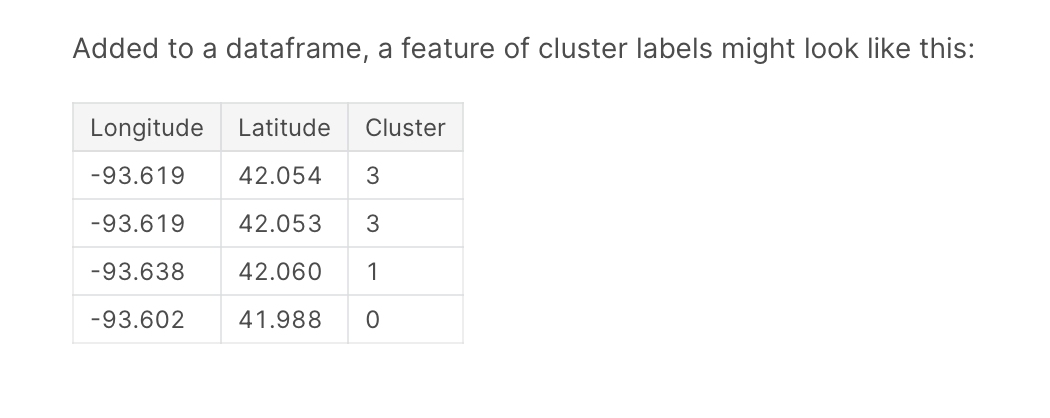

1. It's important to remember that this *cluster* feature is categorical. Here, 
it's shown with a label encoding (that is, as a sequence of integers) as a typical clustering algorithm would produce; depending on your model, a one-hot encoding may be more appropriate.

2. The motivating idea for adding cluster labels is that the clusters will break up complicated relationships across features into simpler chunks. Our model can then just learn the simpler chunks one-by-one instead having to learn the complicated whole all at once. "It's a divide and conquer" approach.



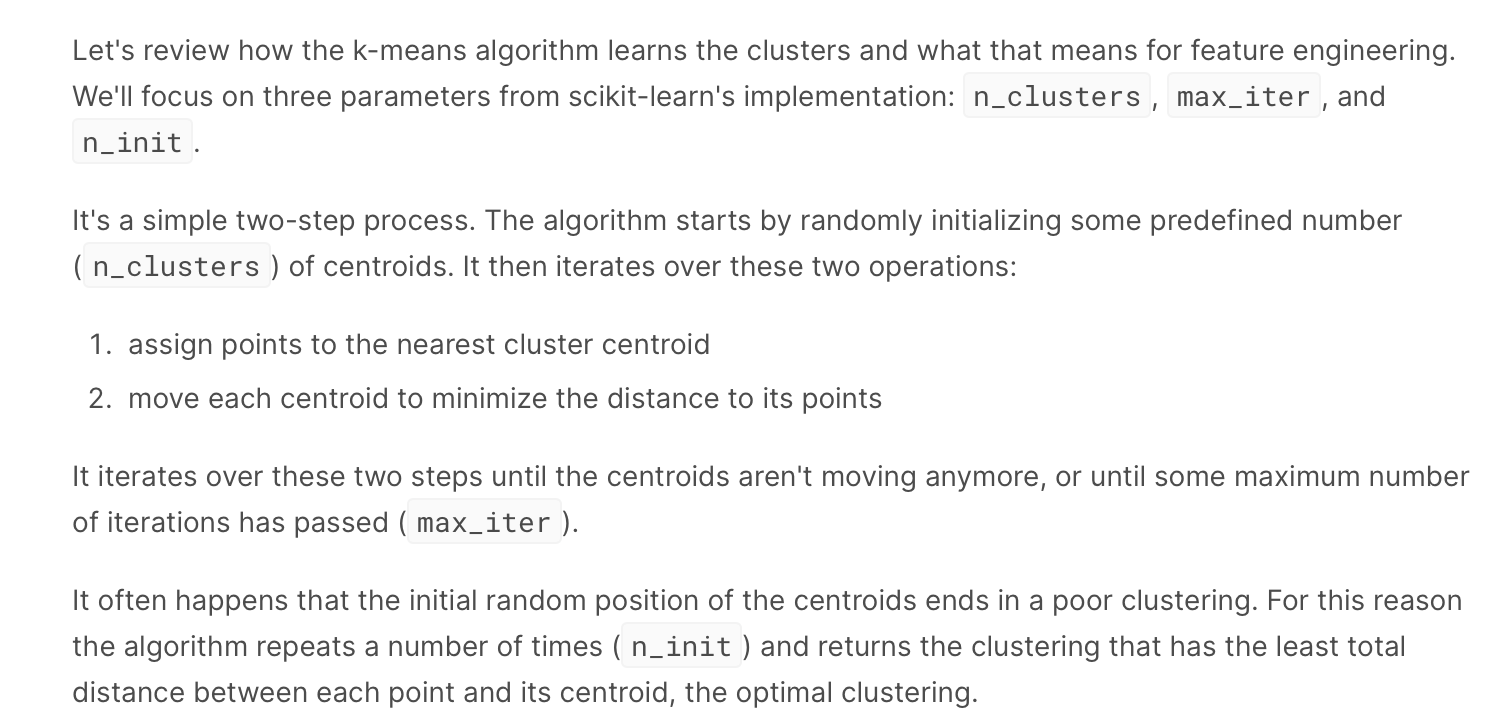

**PCA for Feature Engineering**

There are two ways you could use PCA for feature engineering.

1. The first way is to use it as a descriptive technique. Since the components tell you about the variation, you could compute the MI scores for the components and see what kind of variation is most predictive of your target. That could give you ideas for kinds of features to create -- a product of "Height" and "Diameter" if "Size" is important, say, or a ratio of "Height" and "Diameter" if "Shape" is important. You could even try clustering on one or more of the high-scoring components.

2. The second way is to use the components themselves as features. Because the components expose the variational structure of the data directly, they can often be more informative than the original features. Here are some use-cases:

     *   **Dimensionality reduction:** When your features are highly redundant (multicollinear, specifically), PCA will partition out the redundancy into one or more near-zero variance components, which you can then drop since they will contain little or no information.
     *   **Anomoly detection:** Unusual variation, not apparent from the original features, will often show up in the low-variance components. These could be highly informative in an anomoly or outlier detection task.

     * **Noise reduction:** A collection of sensor readings will often share some common background noise. PCA can sometimes collect the (informative) signal into a smaller number of features while leaving the noise alone, thus boosting the signal-to-noise ratio.

     * **Decorrelation:** Some ML algorithms struggle with highly-correlated features. PCA transforms correlated features into uncorrelated components, which could be easier for your algorithm to work with.



**PCA Best Practices:**
There are a few things to keep in mind when applying PCA:

  * PCA only works with numeric features, like continuous quantities or counts.
  * PCA is sensitive to scale. It's good practice to standardize your data before applying PCA, unless you know you have good reason not to.
  * Consider removing or constraining outliers, since they can have an undue influence on the results.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


df = pd.read_csv("/content/Automobile_data.csv")

In [ ]:
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


In [ ]:
features = ["highway-mpg", "engine-size", "horsepower", "curb-weight"]

X = df.copy()
y = X.pop('price')
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [ ]:
X_scaled.head()

,curb-weight,engine-size,highway-mpg,horsepower
0,-0.014531,0.074267,-0.544725,NaN
1,-0.014531,0.074267,-0.544725,NaN
2,0.513625,0.602571,-0.689938,NaN
3,-0.419770,-0.430023,-0.109087,NaN
4,0.515545,0.218350,-1.270789,NaN


**Target Encoding**

Most of the techniques we've seen in this course have been for numerical features. The technique we'll look at in this lesson, *target encoding*, is instead for categorical features. It's a method of encoding categories as numbers, like one-hot encoding, with the difference that it also uses that *target* to create the encoding. This makes it what we call a **supervised** feature engineering technique.

A **target encoding** is any kind of encoding that replaces a feature's categories with some number derived from the target.

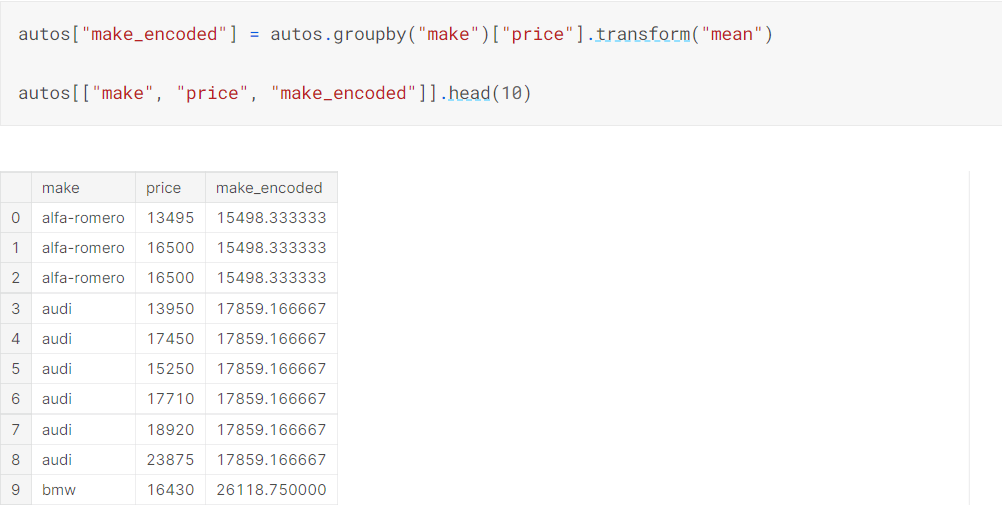

This kind of target encoding is sometimes called a **mean encoding**. Applied to a binary target, it's also called **bin counting**. (Other names you might come across include: likelihood encoding, impact encoding, and leave-one-out encoding.)

**Smoothing:**

An encoding like this presents a couple of problems, however. First are *unknown* categories. Target encodings create a special risk of overfitting, which means they need to be trained on an independent "encoding" split. When you join the encoding to future splits, Pandas will fill in missing values for any categories not present in the encoding split. These missing values you would have to impute somehow.

Second are *rare categories*. When a category only occurs a few times in the dataset, any statistics calculated on its group are unlikely to be very accurate. In the *automobile* dataset, the mercury make only occurs once. The "mean" price we calculated is just the price of that one vehicle, which might not be very representative of any Mercuries we might see in the future. Target encoding rare categories can make overfitting more likely.

A solution to these problems is to add **smoothing**. The idea is to blend the *in-category* average with the *overall* average. Rare categories get less weight on their category average, while missing categories just get the overall average.

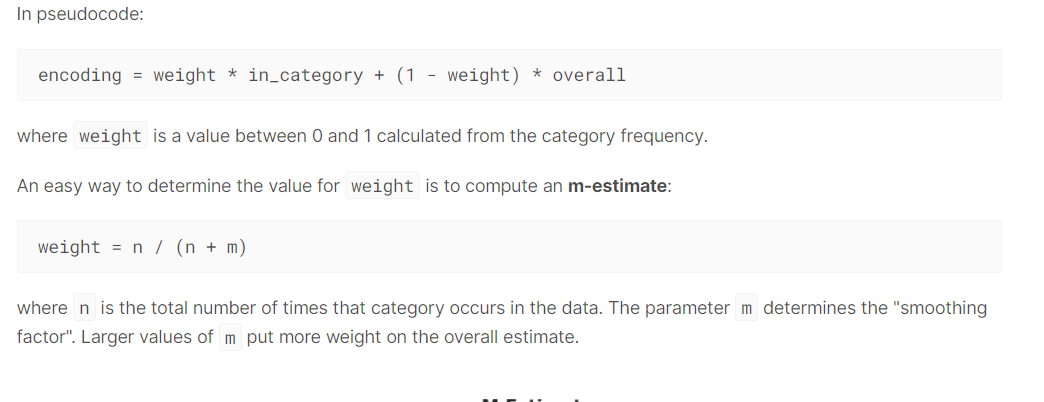

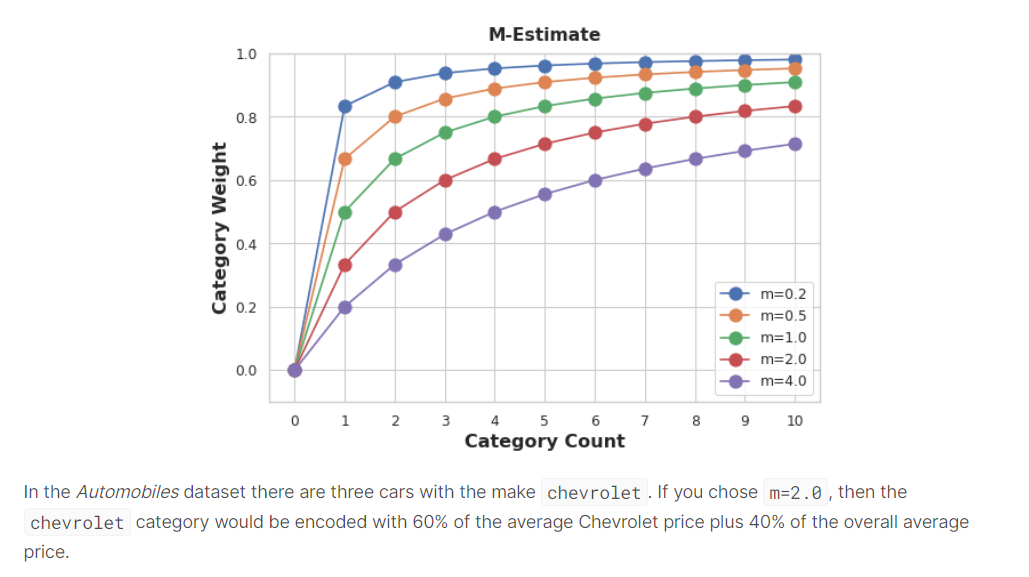

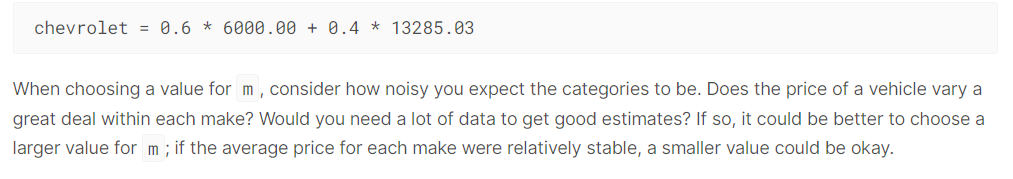

**Use Cases for Target Encoding**
Target encoding is great for:

* **High-cardinality features:** A feature with a large number of categories can be troublesome to encode: a one-hot encoding would generate too many features and alternatives, like a label-encoding, might not be appropriate for that feature. A target encoding derives numbers for the categories using the feature's most important property: its relationship with target.

* **Domain-motivated features:** From prior experience, you might suspect that a categorical feature should be important even if it scored poorly with a feature metric. A target encoding can help reveal a feature's true informativeness.

For more details:

https://www.kaggle.com/code/ryanholbrook/principal-component-analysis

**Data Cleaning**

*   Handling Missing values
*   Scaling and Normalization
*   Parsing Dates
*   Character Encodings: 
      
      * Character encodings are specific sets of rules for mapping from raw binary byte of strings (that look like this: 0110100001101001) to characters that make up human-readable text (like: "hi"). There are many different encodings, and if you tried to read in text with a different encoding than the one it was originally written in, you ended up with scrambled text called "mojibake". Here is an example of mojibake: æ–‡å—åŒ–ã??

      * You might also end up with a "unknown" characters. There are what gets printed when there's no mapping between a particular byte and a character in the encoding you're using to read your byte string in and they look like this: ����������

      * Character encoding mismatches are less common today than they used to be, but it's definitely still a problem. There are lots of different character encodings, but the main one you need to know is UTF-8.

      * UTF-8 is the standard text encoding. All python code is in UTF-8 and, ideally, all your data should be as well. It's when things aren't in UTF-8 that you run into trouble.

      * It was pretty hard to deal with encodings in Python 2, but thankfully in Python 3 it's a lot simpler. (Kaggle Notebooks only use Python 3) There are two main data types you'll encounter when working with text in Python 3. One is the string, which is what text is by default.

*   Inconsistent Data Entry



In [2]:
import chardet

In [3]:
# start with the string
before = "This is the euro symbol: €"

# check to see what datatype it is
type(before)

str

The other data is the bytes data type, which is a sequence of integers. You can convert a string into bytes by specifying which encoding it's in: 

In [4]:
# encode it to a different encoding. replacing characters that raise errors
after = before.encode("utf-8", errors="replace")

# check the type
type(after)

bytes

In [5]:
# take a look at what the bytes look like
after

b'This is the euro symbol: \xe2\x82\xac'

If you look at a bytes object, you'll see that it has a 'b' in front of it, and then maybe some text after. That's because bytes are printed out as if they were characters encoded in ASCII. (ASCII is an older character encoding that doesn't really work for writing any language other than English.) Here you can see that our euro symbol has been replaced with some mojibake that looks like "\xe2\x82\xac" when it's printed as if it were and ASCII string.

When we convert our bytes back to a string with the correct encoding, we can see that our text is all there correclty, which is great :)

In [6]:
# convert it back to utf-8
after.decode('utf-8')

'This is the euro symbol: €'

However, when we try to use a different encoding to map our bytes into a string, we get an error. This is because the encoding we're trying to use doesn't know what to do with the bytes we're trying to pass it. You need to tell Python the encoding that the byte string is actually supposed to be in.

* You can think of different encodings as different ways of recording music. You can record the same music on a CD, cassette tape or 8-track. While the music may sound more-or-less the same, you need to use the right equipment to play the music from each recording format. The correct decoder is like a cassette player or a CD player. If you try to play a cassette in a CD player, it just won't work.

In [7]:
# try to decode our bytes with the ascii encoding
print(after.decode('ascii'))

UnicodeDecodeError: ignored

* We can also run into trouble if we try to use the wrong encoding to map from a string to bytes. Like I said earlier, strings are UTF-8 by default in Python 3, so if we try to treat them like they were in another encoding we'll create problems.

* For example, if we try to convert a string to bytes for ASCII using encode(), we can ask for the bytes to be what they would be if the text was in ASCII. Since our text isn't in ASCII, though, there will be some characters it can't handle. We can automatically replace the characters that ASCII can't handle. If we do that, however, any characters not in ASCII will just be replaced with the unknown character. Then, when we convert the bytes back to a string, the character will be replaced with the unknown character. The dangerous part about this is that there's not way to tell which character it should have been. That means we may have just made our data unusable!

In [8]:
# start with a string
before = "This is the euro symbol: €"

# encode it to a different encoding, replacing characters that raise errors
after = before.encode("ascii", errors = "replace")

# convert it back to utf-8
print(after.decode("ascii"))

# We've lost the original underlying byte string! It's been 
# replaced with the underlying byte string for the unknown character :(

This is the euro symbol: ?


This is bad and we want to avoid doing it! It's far better to convert all our text to UTF-8 as soon as we can and keep it in that encoding. The best time to convert non UTF-8 input into UTF-8 is when you read in files, which we'll talk about next.

## Reading in files with encoding problems

Most files you'll encounter will probably be encoded with UTF-8. This is what Python expects by default, so most of the time you won't run into problems. However, sometimes you'll get an error like this:

In [ ]:
# try to read in a file not in UTF-8
kickstarter_2016 = pd.read_csv("../input/kickstarter-projects/ks-projects-201612.csv")

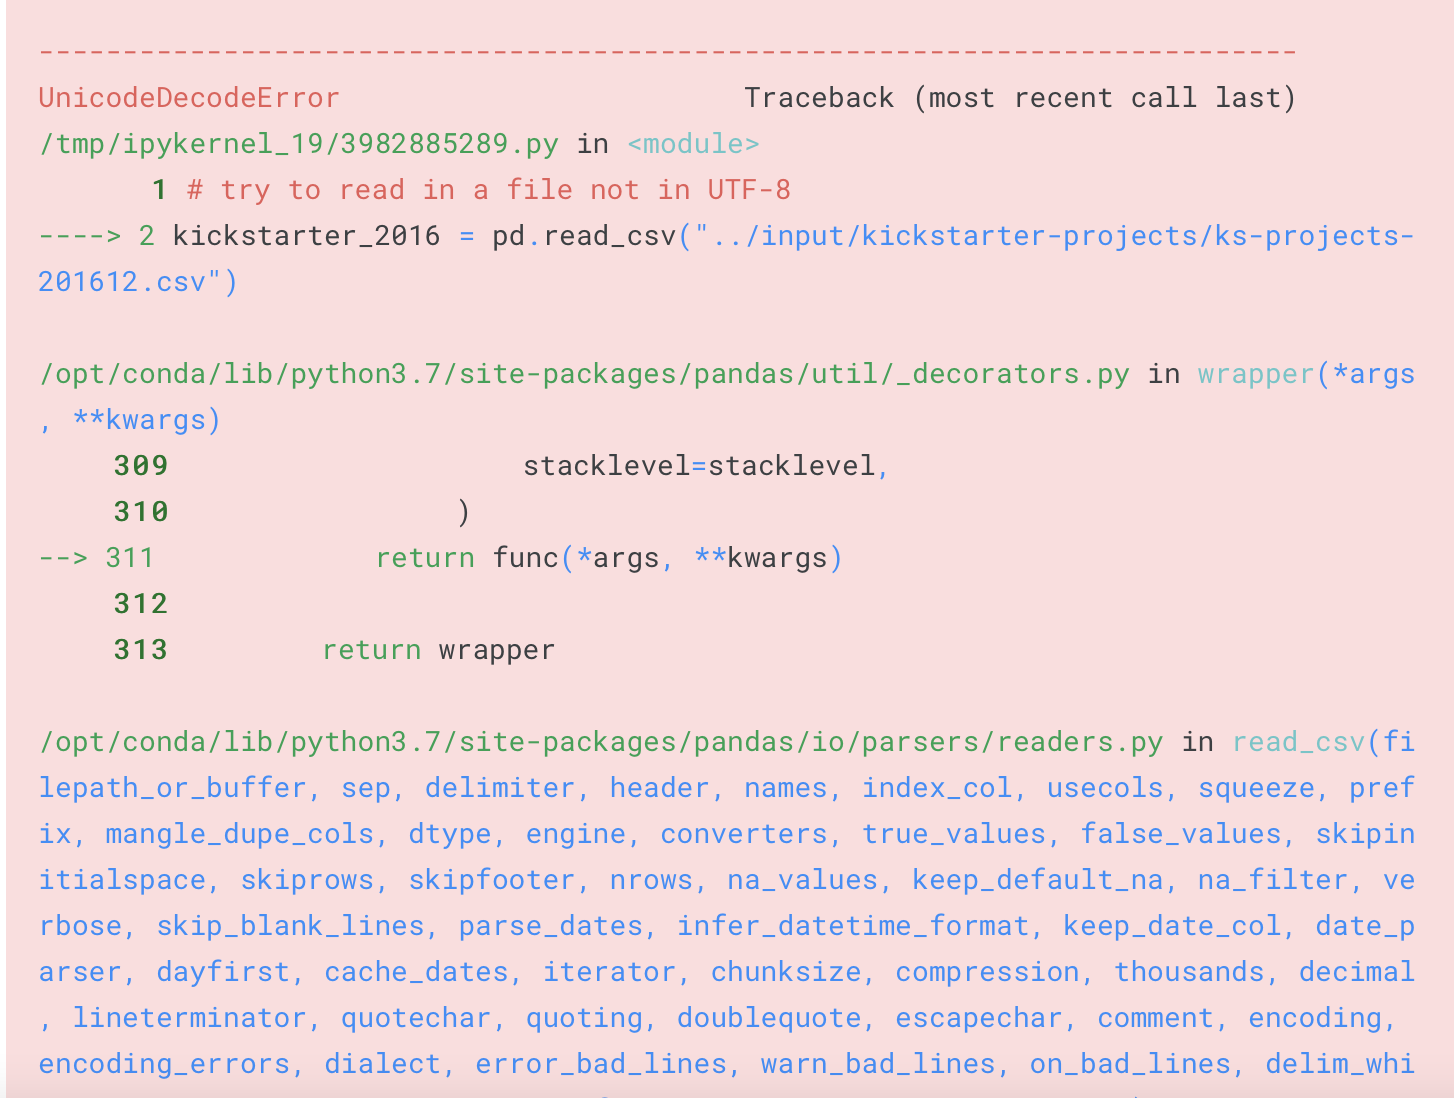

* Notice that we get the same UnicodeDecodeError we got when we tried to decode UTF-8 bytes as if they were ASCII! This tells us that this file isn't actually UTF-8. We don't know what encoding it actually is though. One way to figure it out is to try and test a bunch of different character encodings and see if any of them work. A better way, though, is to use the chardet module to try and automatically guess what the right encoding is. It's not 100% guaranteed to be right, but it's usually faster than just trying to guess.

* I'm going to just look at the first ten thousand bytes of this file. This is usually enough for a good guess about what the encoding is and is much faster than trying to look at the whole file. (Especially with a large file this can be very slow.) Another reason to just look at the first part of the file is that we can see by looking at the error message that the first problem is the 11th character. So we probably only need to look at the first little bit of the file to figure out what's going on.

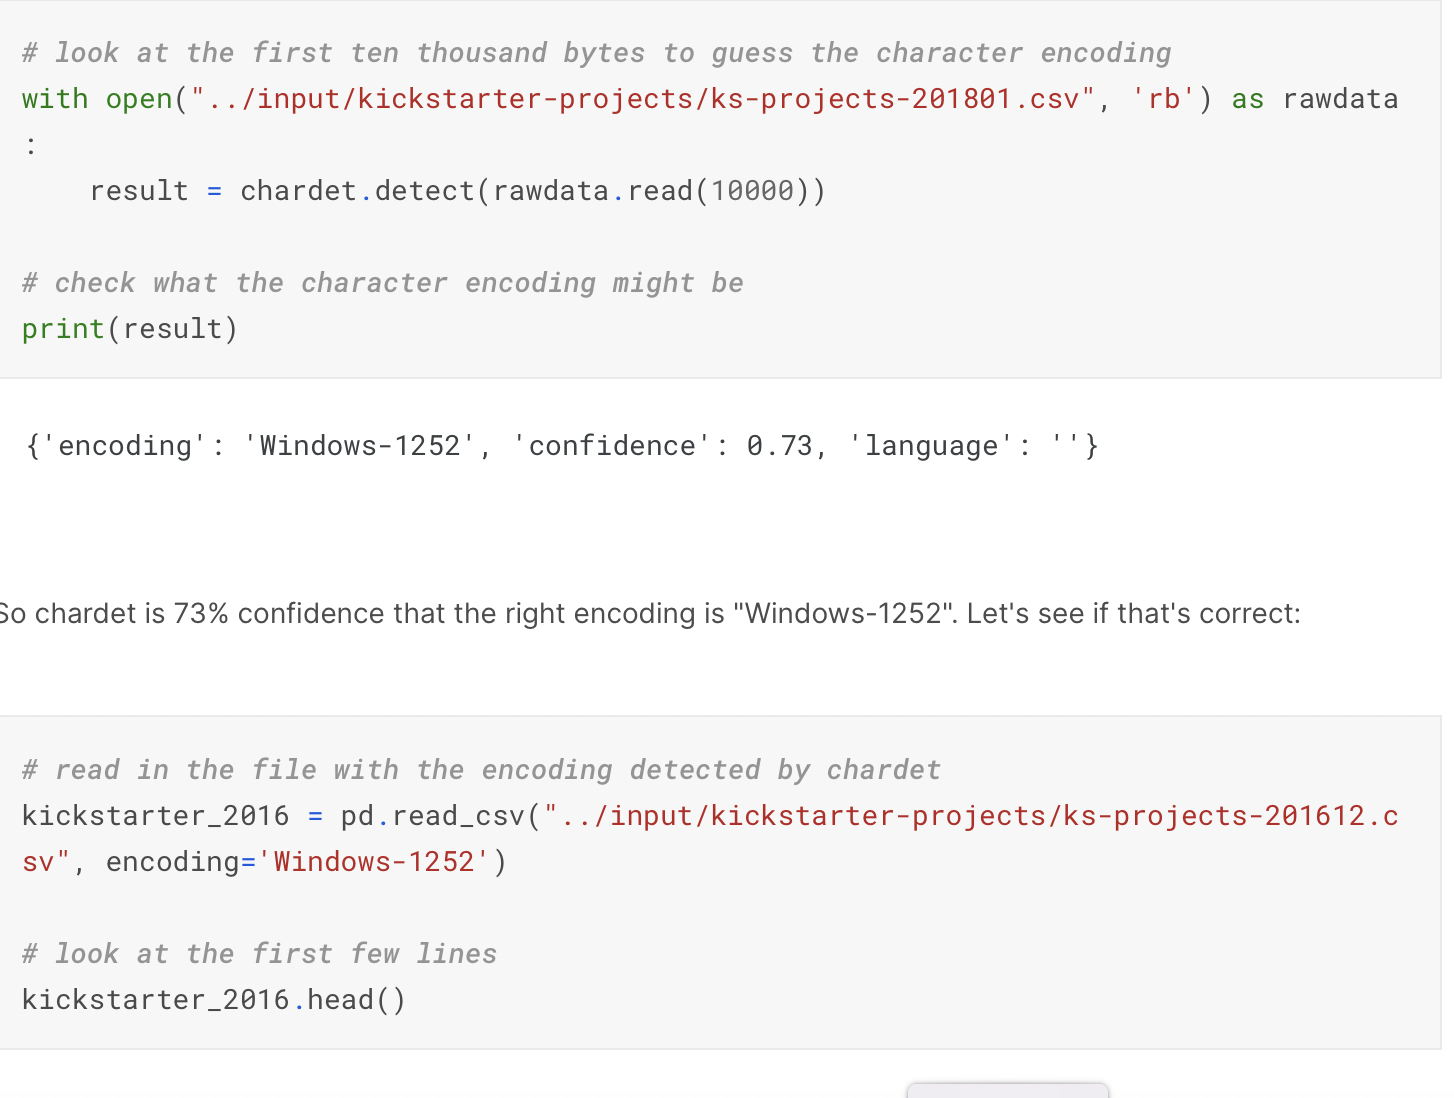

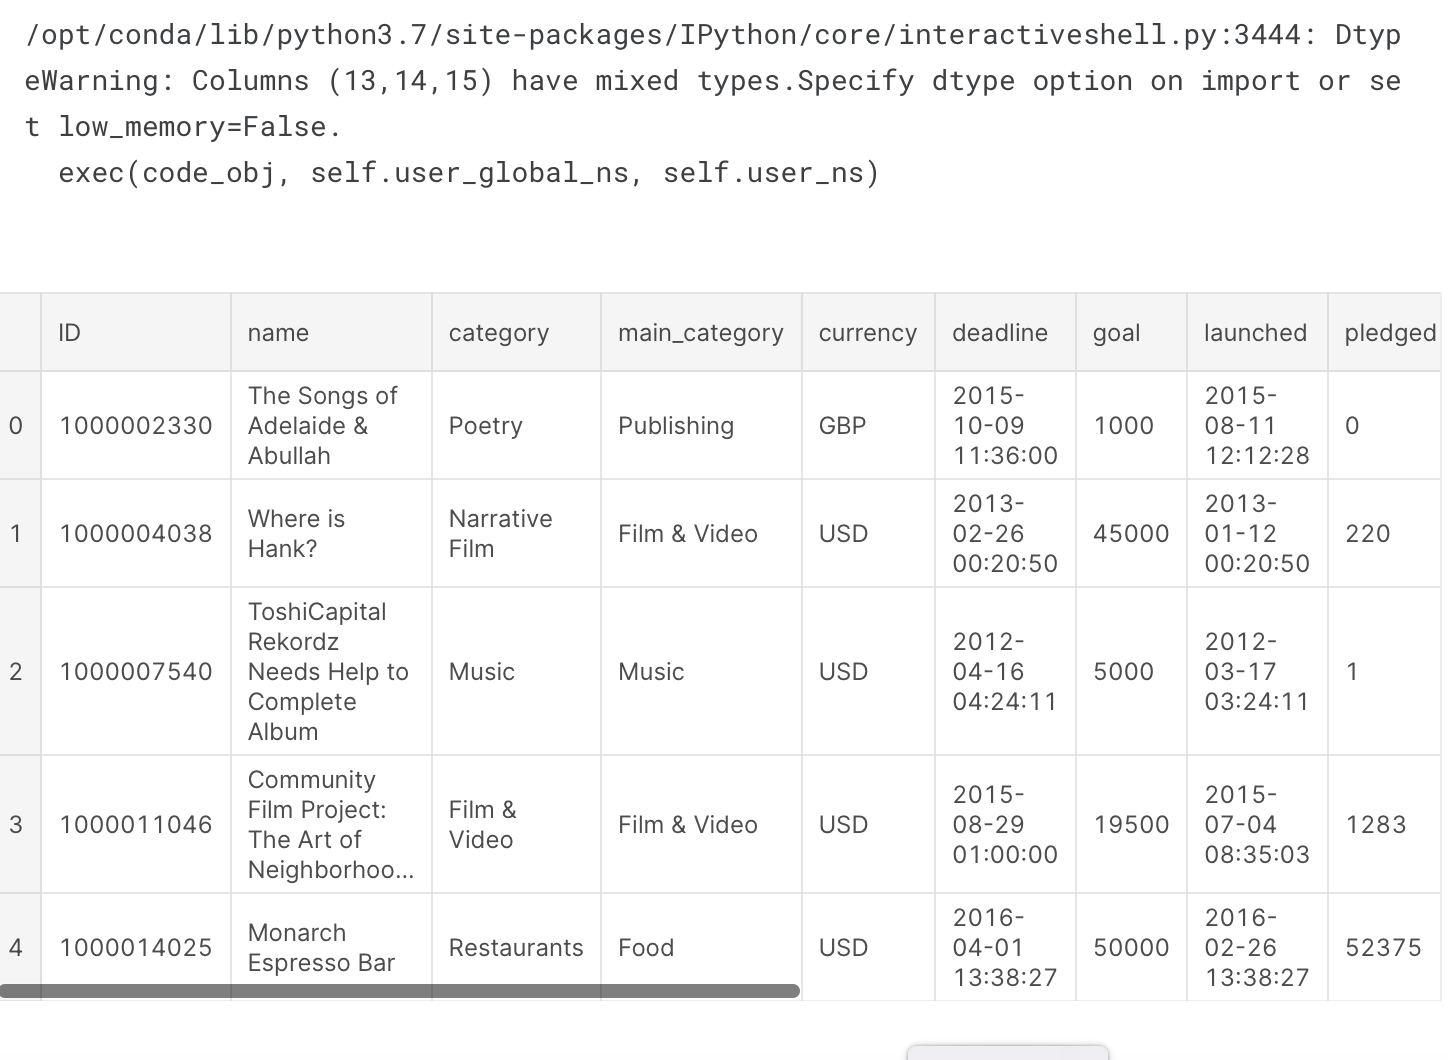

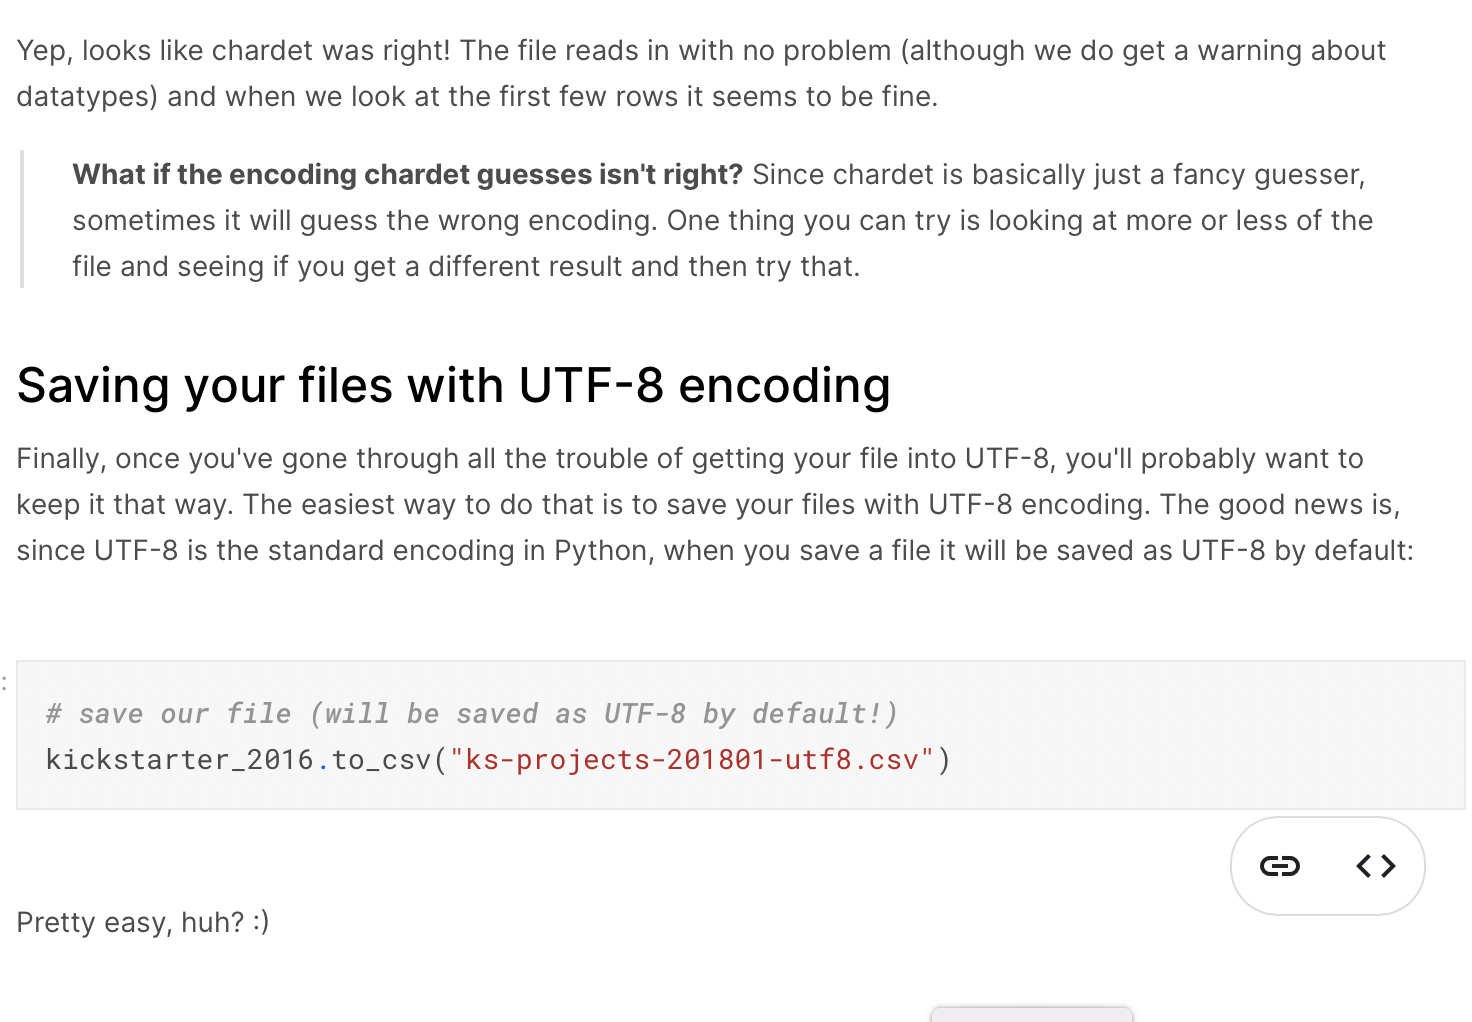